In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# author data descriptive statistics

## JASIST

In [161]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

path = os.getcwd()

scient_coauthor_path = path+"\\data transformation output\\scientometrics\\co-author\\"
scient_cooccurr_path = path+"\\data transformation output\\scientometrics\\co-occurrence\\"
jasist_coauthor_path = path+"\\data transformation output\\jasist\\co-author\\"
jasist_cooccurr_path = path+"\\data transformation output\\jasist\\co-occurrence\\"

f_paths = [#scient_coauthor_path\
           #, scient_cooccurr_path\
            jasist_coauthor_path\
           , jasist_cooccurr_path\
          ]

In [148]:
os.listdir(f_paths[0])

['2010-2015_edge.csv',
 '2010-2015_node.csv',
 '2010-2015_wos.csv',
 '2010-2016_edge.csv',
 '2010-2016_node.csv',
 '2010-2016_wos.csv',
 '2010-2017_edge.csv',
 '2010-2017_node.csv',
 '2010-2017_wos.csv',
 '2010-2018_edge.csv',
 '2010-2018_node.csv',
 '2010-2018_wos.csv',
 '2010-2019_edge.csv',
 '2010-2019_node.csv',
 '2010-2019_wos.csv']

In [149]:
def read_nodes_edges_by_transformed_data(f_path):
    nodes_f_paths, edges_f_paths, wos_f_paths = [], [], []
    times = []
    for f in os.listdir(f_path):
        if f.endswith('node.csv'):
            nodes_f_paths.append(f_path+f)
        elif f.endswith('edge.csv'):
            edges_f_paths.append(f_path+f)
        elif f.endswith('wos.csv'):
            wos_f_paths.append(f_path+f)
        times.append(f.split("_")[0])
        
    df_nodes, df_edges, df_all_times = [], [], []
    for f in nodes_f_paths:
        df_node = pd.read_csv(f)
        df_nodes.append(df_node)
    for f in edges_f_paths:
        df_edge = pd.read_csv(f)
        df_edges.append(df_edge)
    for f in wos_f_paths:
        df_wos = pd.read_csv(f)
        df_all_times.append(df_wos)
    
    times = sorted(list(set(times)))
        
    return df_nodes, df_edges, times, df_all_times

In [150]:
def generate_label_edge(df_edges, df_nodes):
    df_label_edges = []
    label_edge = pd.DataFrame(columns=['source', 'target', 'weight'])

    for i, df_edge in enumerate(df_edges):
        label_edge_source, label_edge_target = [], []
        label = list(df_nodes[i]['label'])
        for j in df_edge['source']:
            label_edge_source.append(label[int(j)-1])
        for j in df_edge['target']:
            label_edge_target.append(label[int(j)-1])
        label_edge['source'] = label_edge_source
        label_edge['target'] = label_edge_target
        label_edge['weight'] = df_edge['weight']

        df_label_edges.append(label_edge)
        label_edge = pd.DataFrame(columns=['source', 'target', 'weight'])
        
    return df_label_edges
# df_label_edges = generate_label_edge(df_edges, df_nodes)

In [151]:
def generate_all_node_id_table(df_nodes):
    all_node_id_table = pd.DataFrame(columns=['id', 'label'])
    for t, df_node in enumerate(df_nodes):
        all_node_id_table = all_node_id_table.append(df_node[['id', 'label']])

    all_node_id_table = all_node_id_table.drop_duplicates(subset='label')
    all_node_id_table['id'] = list(range(1,len(all_node_id_table)+1))
    return all_node_id_table

# all_node_id_table = generate_all_node_id_table(df_nodes)

In [152]:
def generate_uniq_id_node_edge(all_label_list, df_label_edges, df_nodes):
    # no needed if importing transformed data

    df_nodes_uniq_id = []
    df_edges_uniq_id = []
    
    df_node_uniq_id = pd.DataFrame(columns=['id', 'label'])
    df_edge_uniq_id = pd.DataFrame(columns=['source', 'target', 'weight'])
    for i, df_label_edge in enumerate(df_label_edges):
        source_list = list(df_label_edge['source'])
        target_list = list(df_label_edge['target'])
        node_label_list = list(df_nodes[i]['label'])
        
        source_list_id, target_list_id, node_label_list_id = [], [], []
        
        for source_label in source_list:
            source_list_id.append(all_label_list.index(source_label)+1)
        for target_label in target_list:
            target_list_id.append(all_label_list.index(target_label)+1)
        for node_label in node_label_list:
            node_label_list_id.append(all_label_list.index(node_label)+1)
        
        df_edge_uniq_id['source'] = source_list_id
        df_edge_uniq_id['target'] = target_list_id
        df_edge_uniq_id['weight'] = df_label_edge['weight']
        
        df_node_uniq_id['id'] = node_label_list_id
        df_node_uniq_id['label'] = df_nodes[i]['label']
        
        df_nodes_uniq_id.append(df_node_uniq_id)
        df_edges_uniq_id.append(df_edge_uniq_id)
        
        df_node_uniq_id = pd.DataFrame(columns=['id', 'label'])
        df_edge_uniq_id = pd.DataFrame(columns=['source', 'target', 'weight'])
                
    return df_nodes_uniq_id, df_edges_uniq_id

In [153]:
def generate_origin_density(node_list, df_edges, df1, t):
    # the number of nodes in node and edge are different
    for i, n in enumerate(node_list):
    #     print(i, '\t', len(n), len(df_nodes[i]), len(df_edges[i]))
        possible_links = (len(n)*(len(n)-1))/2 # (n * (n-1))/2
        sum_weights = df_edges[i]['weight'].astype(int).sum()
        avg_density = sum_weights/possible_links

        df1.at[t[i], 'origin_node'] = int(len(n))
        df1.at[t[i], 'origin_edge'] = int(len(df_edges[i]))
        df1.at[t[i], 'origin_sum_weight'] = sum_weights
        df1.at[t[i], 'origin_possible_links'] = possible_links
        df1.at[t[i], 'origin_avg_density'] = avg_density

# pairs = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
def find_intersect_node_edge(node_list1, node_list2, df_edge1, df_edge2, t, p):
    n1 = node_list1
    n2 = node_list2
    intersect_n12 = list(set(n1).intersection(set(n2)))
    print('Intersection node numbers: ', len(intersect_n12))
    
    e1 = df_edge1
    e2 = df_edge2
    
    df1_intersect = e1[e1['source'].isin(intersect_n12) & e1['target'].isin(intersect_n12)==True]
    df2_intersect = e2[e2['source'].isin(intersect_n12) & e2['target'].isin(intersect_n12)==True]
    print('{} \n\t\t before: {} edges, \n\t\t after:  {} edges'.format(t[p[0]], len(df_edge1), len(df1_intersect)))
    print('--'*20)
    print('{} \n\t\t before: {} edges, \n\t\t after:  {} edges'.format(t[p[1]], len(df_edge2), len(df2_intersect)))
    print('\n', '=='*30, '\n')
    
    return intersect_n12, df1_intersect, df2_intersect

def generate_intersect_density(pairs, node_list, df_edges, df2, t):
    for p in pairs:
        node_list1 = node_list[p[0]]
        node_list2 = node_list[p[1]]
        df_edge1 = df_edges[p[0]]
        df_edge2 = df_edges[p[1]]
        intersect_n12, df1_intersect, df2_intersect = find_intersect_node_edge(node_list1, node_list2, df_edge1, df_edge2, t, p)

        possible_links = (len(intersect_n12)*(len(intersect_n12)-1))/2 # (n * (n-1))/2
        sum_weights = df2_intersect['weight'].astype(int).sum()
        print('Possible Links: {}, \nSum Weights:{}'.format(possible_links, sum_weights))
        avg_density = sum_weights/possible_links    

        df2.at[t[p[1]], 'intersect_node'] = len(intersect_n12)
        df2.at[t[p[1]], 'intersect_edge'] = len(df2_intersect)
        df2.at[t[p[1]], 'intersect_sum_weight'] = sum_weights
        df2.at[t[p[1]], 'intersect_possible_links'] = possible_links
        df2.at[t[p[1]], 'intersect_avg_density'] = avg_density

In [167]:
def plot_density2(df2, df4):

    # title=input('JASIST or SCIENTOMETRICS?')
    # title = f_path.split("\\")[-3]
    plt.figure(figsize=(10, 10))
    plt.plot(df2['intersect_avg_density'], 's-', color = 'r', label="intersect-coauthor") 
    plt.plot(df4['intersect_avg_density'], 's-', color = 'b', label="intersect-cooccurr")
    plt.plot(df2['origin_avg_density'], 'o-',color = 'r', label="original-coauthor")
    plt.plot(df4['origin_avg_density'], 'o-',color = 'b', label="original-cooccurr")
    plt.legend(loc = "best", fontsize=10)
    plt.title('{} compare {} author/keywords AVG. DENSITY'.format('weighted', 'scientometrics'))
    plt.xlabel('Time Interval')
    plt.ylabel('Avg. Density')
    fig = plt.gcf()
    fig.savefig(os.getcwd()+'\\output figure\\{} compare {} author_keywords AVG. DENSITY.png'.format('weighted', 'scientometrics'))
    plt.show()
# plot_density(df2_jasist)
# plot_density(df2_scient)

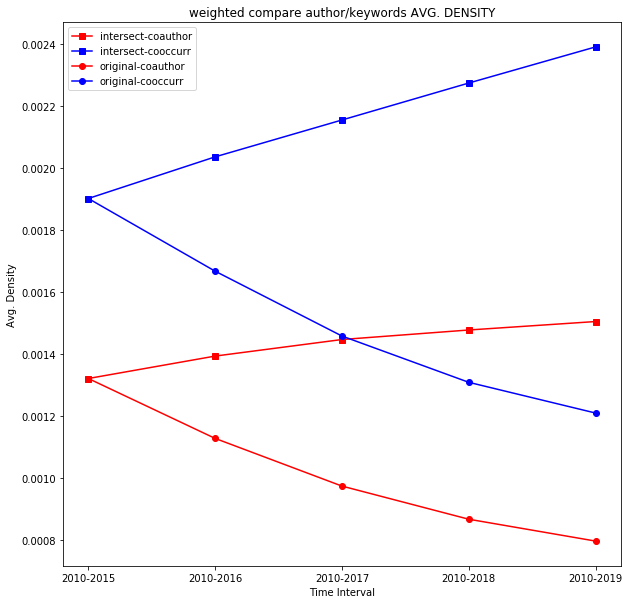

In [158]:
plot_density2(df_coauthor, df_cooccurr)

In [138]:
def plot_density(df2, df4, f_path):

    # title=input('JASIST or SCIENTOMETRICS?')
    title = f_path.split("\\")[-3]
    plt.figure(figsize=(10, 10))
    plt.plot(df2['intersect_avg_density'], 's-', color = 'r', label="intersect-weighted")
    plt.plot(df4['intersect_avg_density'], 's-', color = 'b', label="intersect-binary")
    plt.plot(df2['origin_avg_density'], 'o-',color = 'g', label="origin-weighted")
    plt.plot(df4['origin_avg_density'], 'o-',color = 'y', label="origin-binary")
    plt.legend(loc = "best", fontsize=10)
    plt.title('{} co-occurrence AVG. DENSITY'.format(title))
    plt.xlabel('Time Interval')
    plt.ylabel('Avg. Density')
    fig = plt.gcf()
    fig.savefig(os.getcwd()+'\\output figure\\{}_co-occurrence AVG. DENSITY.png'.format(title))
    plt.show()
# plot_density(df2_jasist)
# plot_density(df2_scient)

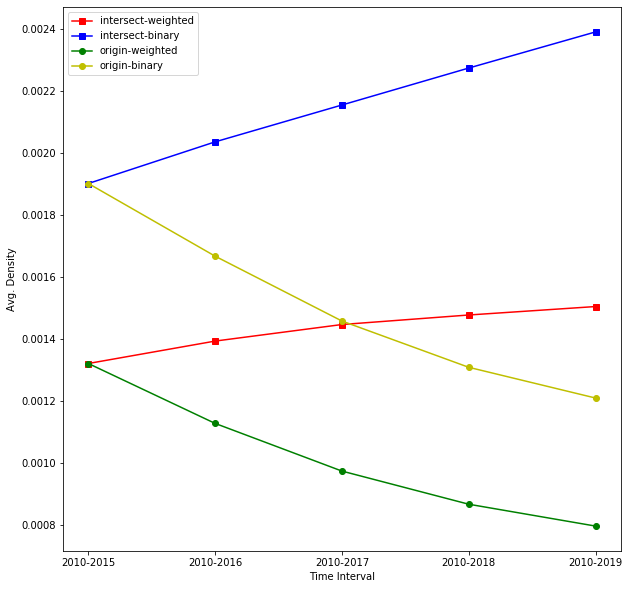

In [140]:
plot_density(df_coauthor, df_cooccurr)

In [127]:
def main(f_path):
    print('\n', "-"*10, f_path)
    df_nodes, df_edges, times, df_all_times = read_nodes_edges_by_transformed_data(f_path)
    
    node_list = []
    for df in df_nodes:
        # nodes = generate_node(df)
        nodes = list(map(str, list(df['id'])))
        node_list.append(nodes)
    # 
    df_edges1 = []
    for df_edge in df_edges:
        df_new_edge = df_edge[['source', 'target', 'weight']]
        df_new_edge['weight'] = [1]*len(df_edge)
        print("+"*20, len(df_new_edge))
        df_edges1.append(df_new_edge)
        
    df1 = pd.DataFrame(data=np.zeros((5,5)), columns = ['origin_node', 'origin_edge', 'origin_sum_weight', 'origin_possible_links', 'origin_avg_density'])
    df1.index=times
    df3 = pd.DataFrame(data=np.zeros((5,5)), columns = ['origin_node', 'origin_edge', 'origin_sum_weight', 'origin_possible_links', 'origin_avg_density'])
    df3.index=times

    generate_origin_density(node_list, df_edges, df1, times)
    generate_origin_density(node_list, df_edges1, df3, times)

    df2 = pd.DataFrame(data=np.zeros((5,5)), columns = ['intersect_node', 'intersect_edge', 'intersect_sum_weight', 'intersect_possible_links', 'intersect_avg_density'])
    df2.index=times
    df2 = df2.join(df1) # weighted

    df4 = pd.DataFrame(data=np.zeros((5,5)), columns = ['intersect_node', 'intersect_edge', 'intersect_sum_weight', 'intersect_possible_links', 'intersect_avg_density'])
    df4.index=times
    df4 = df4.join(df3) # binary
    
    pairs = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
    generate_intersect_density(pairs, node_list, df_edges, df2, times)
    generate_intersect_density(pairs, node_list, df_edges1, df4, times)
    
    return df_nodes, df_edges, df_edges1, node_list, df1, df2, df3, df4

## plot

In [168]:
f_paths = [scient_coauthor_path\
           , scient_cooccurr_path\
           # jasist_coauthor_path\
           #, jasist_cooccurr_path\
          ]


 ---------- C:\Users\Liser\Desktop\linchengwei_link_prediction\data transformation output\scientometrics\co-author\
++++++++++++++++++++ 4979
++++++++++++++++++++ 6209
++++++++++++++++++++ 7530
++++++++++++++++++++ 8692
++++++++++++++++++++ 9831
Intersection node numbers:  2942
2010-2015 
		 before: 4979 edges, 
		 after:  4979 edges
----------------------------------------
2010-2015 
		 before: 4979 edges, 
		 after:  4979 edges


Possible Links: 4326211.0, 
Sum Weights:5710
Intersection node numbers:  2942
2010-2015 
		 before: 4979 edges, 
		 after:  4979 edges
----------------------------------------
2010-2016 
		 before: 6209 edges, 
		 after:  5113 edges


Possible Links: 4326211.0, 
Sum Weights:6023
Intersection node numbers:  2942
2010-2015 
		 before: 4979 edges, 
		 after:  4979 edges
----------------------------------------
2010-2017 
		 before: 7530 edges, 
		 after:  5212 edges


Possible Links: 4326211.0, 
Sum Weights:6254
Intersection node numbers:  2942
2010-2015 
		 b

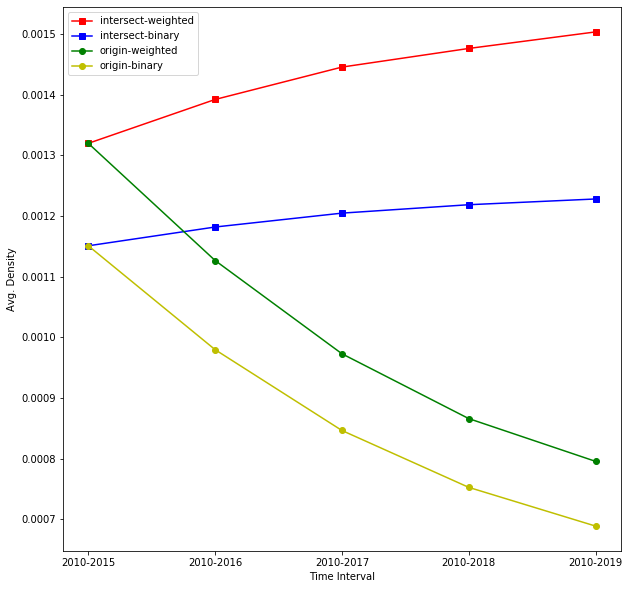


 ---------- C:\Users\Liser\Desktop\linchengwei_link_prediction\data transformation output\scientometrics\co-occurrence\
++++++++++++++++++++ 17305
++++++++++++++++++++ 21010
++++++++++++++++++++ 25032
++++++++++++++++++++ 29350
++++++++++++++++++++ 33293
Intersection node numbers:  4408
2010-2015 
		 before: 17305 edges, 
		 after:  17305 edges
----------------------------------------
2010-2015 
		 before: 17305 edges, 
		 after:  17305 edges


Possible Links: 9713028.0, 
Sum Weights:18460
Intersection node numbers:  4408
2010-2015 
		 before: 17305 edges, 
		 after:  17305 edges
----------------------------------------
2010-2016 
		 before: 21010 edges, 
		 after:  18306 edges


Possible Links: 9713028.0, 
Sum Weights:19765
Intersection node numbers:  4408
2010-2015 
		 before: 17305 edges, 
		 after:  17305 edges
----------------------------------------
2010-2017 
		 before: 25032 edges, 
		 after:  19234 edges


Possible Links: 9713028.0, 
Sum Weights:20920
Intersection node number

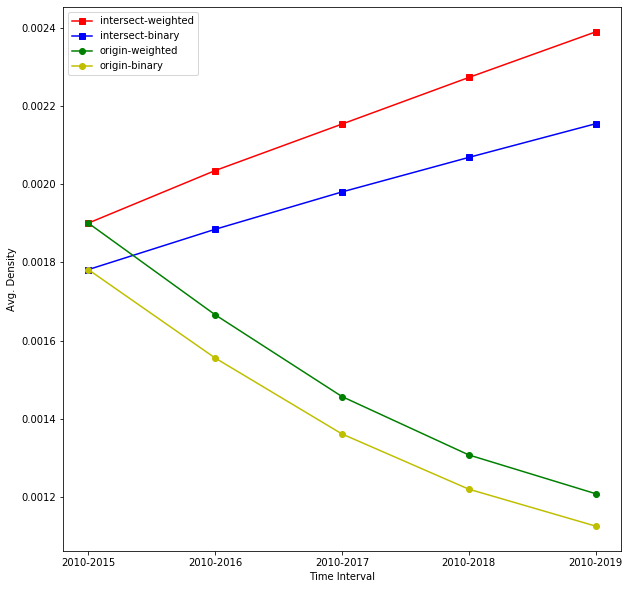

In [169]:
compare = []
for f_path in f_paths:
    df_nodes, df_edges, df_edges1, node_list, df1, df2, df3, df4 = main(f_path)
    now = datetime.now()
    now = now.strftime("%Y_%m-%d_%H:%M")
    compare.append([df2, df4])
    plot_density(df2, df4)
#     break

In [170]:
# weighted
df_coauthor = compare[0][0]
df_cooccurr = compare[1][0]

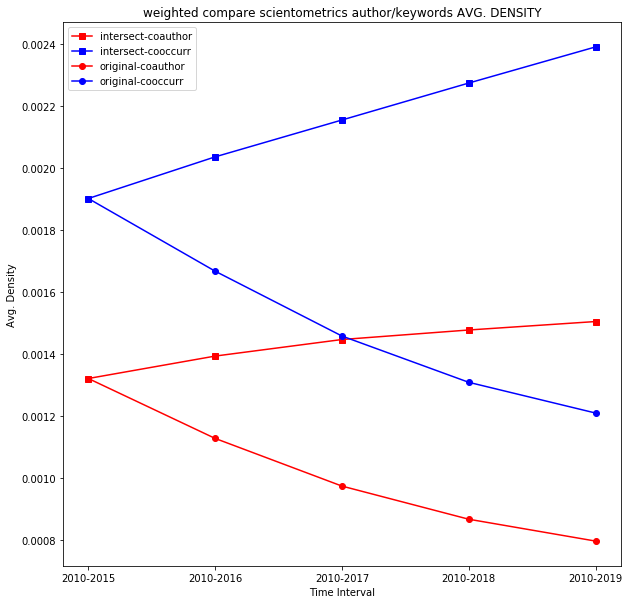

In [171]:
plot_density2(df_coauthor, df_cooccurr)

## Generate .net file

    *network Informetrics1990-2004
    *vertices 632
    632 "Shailendra, K"
    *edges
    1 402 1

In [41]:
def generate_netfiles(files, df_nodes, df_edges, node_list):
    netfile_names = []
    file_name_pref = input('INPUT FILE NAME PREFIX:\t') # scientometrics_coauthor_, JASIST_coauthor_
    for file in files:

        #print("{}".format(file_name_pref)+file)
        netfile_names.append("{}".format(file_name_pref)+file)

    # scientometric_data_2010-2014
    for file_index, netfile_name in enumerate(netfile_names):
        f = open(os.getcwd()+"\\output\\netfiles\\origin\\{}.net".format(netfile_name), "w", encoding='utf-8')
        f.write("*{}\n".format(netfile_name))

        f.write("*vertices {}\n".format(len(node_list[file_index])))
        df_node = df_nodes[file_index]
        for i in range(len(node_list[file_index])):
            label = df_node[df_node['id']==int(node_list[file_index][i])]['label'].values[0]
            f.write('{} "{}"\n'.format(node_list[file_index][i], label))
    #     print("node written")
        f.write('*edges\n')
        for i in range(len(df_edges[file_index])):
            source = int(df_edges[file_index].loc[i][0])
            target = int(df_edges[file_index].loc[i][1])
            weight = int(df_edges[file_index].loc[i][2])
            f.write("{} {} {}\n".format(source, target, weight))
        f.close()
        print('--'*15, netfile_name, '--'*15)
        
generate_netfiles(jasist_files, df_nodes_jasist, df_edges_jasist, node_list_jasist)
generate_netfiles(scient_files, df_nodes_scient, df_edges_scient, node_list_scient)

INPUT FILE NAME PREFIX:	JASIST
------------------------------ JASISTjasist_2010-2015 ------------------------------
------------------------------ JASISTjasist_2010-2016 ------------------------------
------------------------------ JASISTjasist_2010-2017 ------------------------------
------------------------------ JASISTjasist_2010-2018 ------------------------------
------------------------------ JASISTjasist_2010-2019 ------------------------------
INPUT FILE NAME PREFIX:	SCIENT
------------------------------ SCIENT2010-2015 ------------------------------
------------------------------ SCIENT2010-2016 ------------------------------
------------------------------ SCIENT2010-2017 ------------------------------
------------------------------ SCIENT2010-2018 ------------------------------
------------------------------ SCIENT2010-2019 ------------------------------


In [62]:
len(df_nodes_jasist[0])

920

In [63]:
len(df_nodes_scient[0])

2926

In [56]:
# t = scient_files
# pairs = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
# p = pairs[4]

# node_list1, node_list2, df_edge1, df_edge2 = node_list_scient[p[0]], node_list_scient[p[1]], df_edges_scient[p[0]], df_edges_scient[p[1]]

# intersect_n12, df1_intersect, df2_intersect = find_intersect_node_edge(node_list1, node_list2, df_edge1, df_edge2, t, p)

In [57]:
path = os.getcwd()
scientometric_coauthor_path = path+'\\data\\Scientometrics-3\\co-author\\'
scientometric_cooccur_path = path+'\\data\\Scientometrics-3\\co-occurance\\'
jasist_coauthor_path = path+'\\data\\JASIST\\co-author\\'
jasist_cooccur_path = path+'\\data\\JASIST\\co-occurrance\\'

### gml file
    graph
    [
      node
      [
        id 1
        label "" 
        ..
        ..
      ]
      edge
      [
        source 1
        target 2
        value 1
      ]
    ]

In [39]:
def plot_density(df2, df4, f_path):

    # title=input('JASIST or SCIENTOMETRICS?')
    title = f_path.split("\\")[-3]
    plt.figure(figsize=(10, 10))
    plt.plot(df2['intersect_avg_density'], 's-', color = 'r', label="intersect-weighted")
    plt.plot(df4['intersect_avg_density'], 's-', color = 'b', label="intersect-binary")
    plt.plot(df2['origin_avg_density'], 'o-',color = 'g', label="origin-weighted")
    plt.plot(df4['origin_avg_density'], 'o-',color = 'y', label="origin-binary")
    plt.legend(loc = "best", fontsize=10)
    plt.title('{} co-occurrence AVG. DENSITY'.format(title))
    plt.xlabel('Time Interval')
    plt.ylabel('Avg. Density')
    fig = plt.gcf()
    fig.savefig(os.getcwd()+'\\output figure\\{}_co-occurrence AVG. DENSITY.png'.format(title))
    plt.show()
# plot_density(df2_jasist)
# plot_density(df2_scient)